In [2]:
import sys
import os
from itertools import combinations

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication
from optic.config import *
from optic.controls import *
from optic.dialog import *
from optic.gui import *
from optic.io import *
from optic.manager import *
from optic.gui.bind_func import *

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", "Failed to load the file.")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()
        self.initializeDataControlForXYCT()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            self.control_manager.table_controls[app_key].setupWidgetDynamicTable(app_key)

            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            # self.control_manager.view_controls[app_key].setViewSize()
            # self.control_manager.view_controls[app_key].setShowRegImROI(False)
            # self.control_manager.view_controls[app_key].setShowRegStack(False)

        # set "sec" view's slider to "1"
        self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"].setValue(1)
        self.control_manager.view_controls[self.app_keys[1]].setPlaneT(1)
        self.control_manager.table_controls[self.app_keys[1]].setPlaneT(1)

    # for XYCT data, control
    def initializeDataControlForXYCT(self):
        for plane_t in range(self.data_manager.getSizeOfT(self.app_keys[0])):
            self.data_manager.dict_roi_coords_xyct[plane_t] = {}
            self.data_manager.dict_roi_coords_xyct_reg[plane_t] = {}
            self.data_manager.dict_roi_matching["id"][plane_t] = []
            for app_key in self.app_keys:
                self.control_manager.view_controls[app_key].roi_colors_xyct[plane_t] = {}

        list_plane_combi = list(combinations(range(self.data_manager.getSizeOfT(self.app_keys[0])), 2))
        for plane_pri, plane_sec in list_plane_combi:
            # Initialize the nested dictionaries if not already present
            if plane_pri not in self.data_manager.dict_roi_matching["match"]:
                self.data_manager.dict_roi_matching["match"][plane_pri] = {}
            if plane_sec not in self.data_manager.dict_roi_matching["match"][plane_pri]:
                self.data_manager.dict_roi_matching["match"][plane_pri][plane_sec] = {}


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label="tiff stack (XYCT) file path", key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        layout.addLayout(makeLayoutROIManagerForTable(
            self.widget_manager,
            key_button_roi_add=f"{app_key}_roi_add",
            key_button_roi_remove=f"{app_key}_roi_remove",
            key_button_roi_edit=f"{app_key}_roi_edit",
        ))
        layout.addLayout(makeLayoutROIEditConfig(
            self.widget_manager,
            key_label_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_label_pen_radius=f"{app_key}_pen_radius",
            key_slider_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_spinbox_pen_radius=f"{app_key}_pen_radius",
        ))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutMicrogliaXYCTStackRegistration(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],                 
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",          
            f"elastix_config", 
            f"elastix_run_t",   
            f"export_reg_tiff",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_stack",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton("ot_run_all_tplanes", "Run Optimal Transport for all t-planes"))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentCellposeROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCellpose(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],
            "cellpose",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_run",
        ))
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_load",
            "mask_save",
            "mask_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    # View size : Table size = 2 : 1
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]), 1)
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]), 1)
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentCellposeROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # ROI Manager for Table
            bindFuncButtonsROIManagerForTable(
                q_button_add=self.widget_manager.dict_button[f"{app_key}_roi_add"],
                q_button_remove=self.widget_manager.dict_button[f"{app_key}_roi_remove"],
                q_button_edit=self.widget_manager.dict_button[f"{app_key}_roi_edit"],
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                control_manager=self.control_manager,
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                app_key_pri=self.app_keys[0],
                app_key_sec=self.app_keys[1]
            )
            # ROI Edit Config
            bindFuncSliderSpinBoxROIEditConfig(
                q_slider_opacity=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_edit"],
                q_spinbox_radius=self.widget_manager.dict_spinbox[f"{app_key}_pen_radius"],
                view_control=self.control_manager.view_controls[app_key]
            )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # T slider
        bindFuncPlaneTSliderWithXYCTTracking(
            q_slider_pri=self.widget_manager.dict_slider[f"{self.app_keys[0]}_plane_t"],
            q_slider_sec=self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
        )
        # ROI Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )
        # ROI Table onCellChanged
        bindFuncTableCellChangedWithMicrogliaTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            control_manager=self.control_manager,
            data_manager=self.data_manager,
        )
        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["mask_save"],
            q_button_load=self.widget_manager.dict_button["mask_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key=self.app_keys[0]
        )
        # ImageJ ROI Manager zip IO
        bindFuncROIManagerZipIO(
            q_button_save=self.widget_manager.dict_button["roi_save"],
            q_button_load=self.widget_manager.dict_button["roi_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
        )
        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredStack(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_stack'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )
        # run Elastix registration t-axis
        bindFuncButtonRunElastixForMicrogliaXYCTStackRegistration(
            self,
            q_button=self.widget_manager.dict_button[f"elastix_run_t"],
            data_manager=self.data_manager,
            config_manager=self.config_manager,
            app_keys=self.app_keys,
            combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
            combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
            combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
        )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # Microglia Tracking IO
        bindFuncMicrogliaTrackingIO(
            self.widget_manager.dict_button["roi_matching_save"],
            self.widget_manager.dict_button["roi_matching_load"],
            self,
            self.widget_manager.dict_lineedit["path_tiff"],
            self.config_manager,
            self.data_manager,
            self.control_manager,
        )
        # ROI Matching Run
        bindFuncButtonRunROIMatchingForXYCT(
            self,
            q_button_run=self.widget_manager.dict_button['ot_run'],
            q_button_run_all_tplanes=self.widget_manager.dict_button['ot_run_all_tplanes'],
            widget_manager=self.widget_manager,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # Clear ROI Matching result
        bindFuncButtonClearROIMatching(
            q_button=self.widget_manager.dict_button['ot_clear'],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # run Cellpose
        bindFuncButtonRunCellposeForXYCT(
            self.data_manager,
            self.control_manager,
            self.config_manager,
            self.widget_manager.dict_button["cellpose_run"],
            self.widget_manager.dict_combobox["cellpose_t_plane"],
            self.widget_manager.dict_combobox["cellpose_channel"],
            self.widget_manager.dict_combobox["cellpose_model"],
            self.widget_manager.dict_combobox["cellpose_restore"],
            self.widget_manager.dict_spinbox["cellpose_diameter"],
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

ROI load error:  M001_S01
NOT FREEHAND ROI
ROI load error:  M001_S02
NOT FREEHAND ROI
ROI load error:  M001_S03
NOT FREEHAND ROI
ROI load error:  M001_S04
NOT FREEHAND ROI
ROI load error:  M001_S05
NOT FREEHAND ROI
ROI load error:  M001_S06
NOT FREEHAND ROI
ROI load error:  M001_S07
NOT FREEHAND ROI
ROI load error:  M001_S08
NOT FREEHAND ROI
ROI load error:  M002_S01
NOT FREEHAND ROI
ROI load error:  M002_S02
NOT FREEHAND ROI
ROI load error:  M002_S03
NOT FREEHAND ROI
ROI load error:  M002_S04
NOT FREEHAND ROI
ROI load error:  M002_S05
NOT FREEHAND ROI
ROI load error:  M002_S06
NOT FREEHAND ROI
ROI load error:  M002_S07
NOT FREEHAND ROI
ROI load error:  M002_S08
NOT FREEHAND ROI
ROI load error:  M003_S01
NOT FREEHAND ROI
ROI load error:  M003_S02
NOT FREEHAND ROI
ROI load error:  M003_S03
NOT FREEHAND ROI
ROI load error:  M003_S04
NOT FREEHAND ROI
ROI load error:  M003_S05
NOT FREEHAND ROI
ROI load error:  M003_S06
NOT FREEHAND ROI
ROI load error:  M003_S07
NOT FREEHAND ROI
ROI load er

SystemExit: 0

In [61]:
gui.data_manager.getImageSize("pri")

(924, 899)

In [ ]:
from __future__ import annotations

import numpy as np
import cv2

coords = gui.data_manager.dict_roi_coords_xyct[0][0]
xy = np.array([coords["xpix"], coords["ypix"]]).T
width = 1000
height = 1000

# convert ROI contour to filled ROI
def convertContourToFilled(
        roi_contour: np.ndarray[int, int], 
        width: int, 
        height: int
        ) -> np.ndarray[int, int]:
    img = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(img, [roi_contour], 1)
    y, x = np.where(img > 0)
    roi_filled = np.column_stack((x, y))
    return roi_filled

convertContourToFilled(xy, width, height)

array([[809,  78],
       [810,  78],
       [811,  78],
       ...,
       [809, 117],
       [810, 117],
       [811, 117]], dtype=int64)

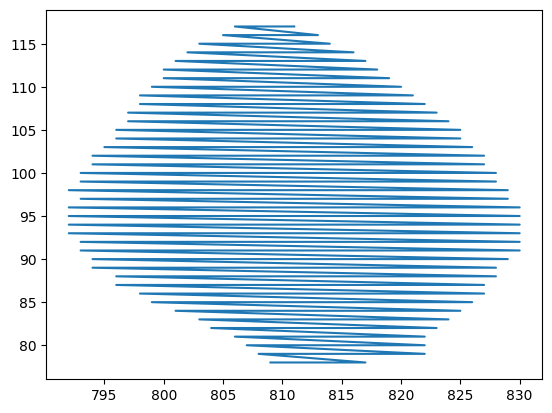

In [54]:
import matplotlib.pyplot as plt

# plt.plot(xy[0], xy[1])
plt.plot(filled[:, 0], filled[:, 1])

In [ ]:
for i in gui.data_manager.dict_roi_matching["id"].keys():
    if not gui.data_manager.dict_roi_matching["id"][i] == list(gui.data_manager.dict_roi_coords_xyct[i].keys()):
        print((gui.data_manager.dict_roi_matching["id"][i]))
        print((list(gui.data_manager.dict_roi_coords_xyct[i].keys())))

[1, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 47, 48, 49, 50, 53, 54, 55]
[1, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 53, 54, 55]
[1, 3, 6, 7, 8, 10, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 41, 42, 43, 44, 46, 47, 47, 48, 49, 50, 51, 53, 54, 55]
[1, 3, 6, 7, 8, 10, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55]
[4, 5, 7, 8, 11, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57]
[4, 5, 7, 8, 11, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44

In [17]:
gui.data_manager.dict_roi_coords_xyct[5].keys()

dict_keys([1, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 53, 54, 55])

In [2]:
gui.data_manager.dict_roi_coords_xyct[0][6]

{'xpix': array([754, 753, 752, 751, 750, 749, 749, 748, 748, 747, 746, 746, 745,
        745, 744, 744, 744, 743, 743, 743, 743, 743, 743, 743, 743, 743,
        743, 744, 745, 746, 746, 747, 748, 749, 750, 751, 752, 753, 754,
        755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767,
        768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780,
        781, 782, 783, 782, 782, 782, 781, 781, 781, 781, 781, 781, 781,
        781, 781, 781, 781, 781, 781, 780, 780, 780, 780, 781, 781, 781,
        780, 780, 780, 780, 779, 779, 778, 777, 776, 775, 774, 773, 772,
        771, 770, 769, 768, 767, 766, 765, 764, 763, 762, 761, 760, 759,
        758, 757, 756, 755]),
 'ypix': array([374, 375, 375, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384,
        385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397,
        398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 408, 409,
        409, 409, 410, 410, 410, 410, 411, 411, 411, 411, 412, 412, 412,
     

In [5]:
gui.data_manager.dict_roi_matching["id"][0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46]

In [1]:
gui.widget_manager.dict_button

NameError: name 'gui' is not defined

In [18]:
# load ROI.zip
from roifile import roiread, roiwrite, ImagejRoi

path_roi_zip = "D:/optic_figure/data/fig5_Saito/LPS 1day/MDA50/MDA50_ROI.zip"

rois = roiread(path_roi_zip)
# display(rois[0])
# display(rois[0].integer_coordinates)

In [ ]:
def loadROIZip(path_roi_zip: str) -> List[ImagejRoi]:
    rois = roiread(path_roi_zip)
    return rois

ImagejRoi(
    roitype=ROI_TYPE.FREEHAND,
    options=ROI_OPTIONS.OVERLAY_BACKGROUNDS | ROI_OPTIONS.OVERLAY_LABELS,
    name='m001-s01',
    version=228,
    top=78,
    left=792,
    bottom=117,
    right=830,
    n_coordinates=103,
    z_position=72,
    t_position=1,
    integer_coordinates=numpy.array([
        [17,  0],
        [16,  1],
        [15,  2],
        [14,  3],
        [13,  4],
        [12,  4],
        [11,  5],
        [10,  6],
        [ 9,  6],
        [ 8,  7],
        [ 7,  7],
        [ 6,  8],
        [ 5,  9],
        [ 4,  9],
        [ 4, 10],
        [ 3, 11],
        [ 2, 11],
        [ 2, 12],
        [ 1, 13],
        [ 1, 14],
        [ 0, 15],
        [ 0, 16],
        [ 0, 17],
        [ 0, 18],
        [ 1, 19],
        [ 0, 20],
        [ 1, 21],
        [ 1, 22],
        [ 2, 23],
        [ 2, 24],
        [ 3, 25],
        [ 4, 26],
        [ 4, 27],
        [ 5, 28],
        [ 5, 29],
        [ 6, 30],
        [ 6, 31],
        [ 7, 32],
       

In [ ]:
from __future__ import annotations

dict_roi_matching = {'id': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []},
 'match': {0: {1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}},
  1: {2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}},
  2: {3: {}, 4: {}, 5: {}, 6: {}, 7: {}},
  3: {4: {}, 5: {}, 6: {}, 7: {}},
  4: {5: {}, 6: {}, 7: {}},
  5: {6: {}, 7: {}},
  6: {7: {}}}}

dict_roi_coords_xyct = {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}}

from typing import List, Dict, Tuple, Optional, Literal

# convert imageJ roi.zip to dict_roi_coords_xyct, dict_roi_matching
"""
ROI format of roi.zip is XYCZT, convert to XYCT format

dict_roi_matching: initialized dict_roi_matching
dict_roi_coords_xyct: initialized dict_roi_coords_xyct
"""
def convertImagejRoiToDictROIMatchingAndDictROICoords(
        rois: List[ImagejRoi],
        dict_roi_matching: Dict[str, Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]],
        dict_roi_coords_xyct: Dict[int, Dict],
    ) -> Tuple[Dict[str, Dict[int, List[int] | Dict[int, Dict[int, Optional[int]]]]], 
               Dict[int, Dict[int, Dict[Literal["x", "y", "med"], np.ndarray]]]]:
    # anchor dict for dict_roi_matching["match"]
    # ex) {"m001": {0: 1, 1: 2, 2: 4, 3: 2}, "m002": {0: 3, 1: 4, 2: 5, 3: 6}}
    dict_roi_matching_anchor: Dict[str, Dict[int, int]] = {}

    # get roi_matching["id"] and roi_coords_xyct
    for i, roi in enumerate(rois):
        roi_name = roi.name # mXXX-sXX

        # only FREEHAND roi !
        if roi.roitype == 7:
            roi_x_start = roi.left
            roi_y_start = roi.top
            roi_xy_coords = roi.integer_coordinates

            xpix = roi_xy_coords[:, 0] + roi_x_start
            ypix = roi_xy_coords[:, 1] + roi_y_start
            med = np.array([np.median(xpix).astype("uint16"), np.median(ypix).astype("uint16")])

            roi_z_plane = roi.z_position - 1
            roi_t_plane = roi.t_position - 1
            
            # WARNING !!!
            # Current roi naming rule is "mXXX-sXX", m : ROI ID, s : t_plane number
            # But, this rule is not always correct.
            name = roi_name.split("-")[0]
            idx_roi = int(name.split("m")[1]) - 1
            # Some ROI's z_position and t_position are 0, it's not correct.
            # In this case, use "sXX" of roi_name as t_plane number.
            if roi_t_plane == -1:
                print("ROI load error: ", roi_name)
                print("NOT CONTAIN t_position")
                roi_t_plane = int(roi_name.split("-")[1].split("s")[1]) - 1
            
            dict_roi_matching["id"][roi_t_plane].append(idx_roi)
            dict_roi_coords_xyct[roi_t_plane][idx_roi] = {
                "xpix": xpix,
                "ypix": ypix,
                "med": med,
            }

            # store roi name, t_plane number and idx_roi
            if name not in dict_roi_matching_anchor:
                dict_roi_matching_anchor[name] = {}
            dict_roi_matching_anchor[name][roi_t_plane] = idx_roi

        else:
            print("ROI load error: ", roi_name)
            print("NOT FREEHAND ROI")

    # get roi_matching["match"]
    for roi in rois:
        roi_name = roi.name
        name = roi_name.split("-")[0]
        # single ROI existing multi planes
        for t_plane_pri in dict_roi_matching["match"].keys():
            for t_plane_sec in dict_roi_matching["match"][t_plane_pri].keys():
                try:
                    idx_roi_pri = dict_roi_matching_anchor[name][t_plane_pri]
                    idx_roi_sec = dict_roi_matching_anchor[name][t_plane_sec]
                    dict_roi_matching["match"][t_plane_pri][t_plane_sec][idx_roi_pri] = idx_roi_sec
                except KeyError:
                    pass

    return dict_roi_matching, dict_roi_coords_xyct



In [15]:
dict_roi_matching["match"][0]

{1: {1: 1,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  46: 46},
 2: {1: 1,
  3: 3,
  4: 4,
  5: 5,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  46: 46},
 3: {1: 1,
  3: 3,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  10: 10,
  11: 11,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
 

In [ ]:
dict_roi_matching

{'m001': {0: 0},
 'm002': {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1},
 'm003': {0: 2},
 'm004': {0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: 3},
 'm005': {0: 4, 1: 4, 2: 4, 4: 4, 5: 4, 7: 4},
 'm006': {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 7: 5},
 'm007': {0: 6, 1: 6, 3: 6, 4: 6, 5: 6, 6: 6},
 'm008': {0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7},
 'm009': {0: 8, 1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8},
 'm010': {0: 9, 1: 9, 2: 9},
 'm011': {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10},
 'm012': {0: 11, 1: 11, 2: 11, 3: 11, 4: 11, 5: 11, 7: 11},
 'm013': {0: 12, 1: 12},
 'm014': {0: 13, 1: 13},
 'm015': {0: 14, 1: 14, 2: 14, 3: 14, 4: 14, 5: 14, 6: 14, 7: 14},
 'm016': {0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15},
 'm017': {0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16},
 'm018': {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17},
 'm019': {0: 18, 1: 18, 2: 18, 3: 18, 4: 18, 5: 18},
 'm020': {1: 19, 0: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19, 7: 1

In [70]:
roi_name

'm002-s08'